In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Tải dữ liệu German Credit
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
column_names = ["existing_account", "duration_month", "credit_history", "purpose", "credit_amount",
                "savings_account", "employment_since", "installment_rate", "personal_status_sex", "other_debtors",
                "present_residence", "property", "age", "other_installment_plans", "housing", "existing_credits",
                "job", "people_liable", "telephone", "foreign_worker", "credit_risk"]

df = pd.read_csv(url, sep=" ", header=None, names=column_names)

# Chuyển đổi target thành nhị phân
df['credit_risk'] = df['credit_risk'].map({1: 0, 2: 1})


In [18]:
from sklearn.base import TransformerMixin, BaseEstimator
import logging
from optbinning import BinningProcess
import matplotlib.pyplot as plt

class InformationValues(BaseEstimator, TransformerMixin):
    def __init__(self, monotonic_trend='auto_asc_desc', max_n_bins=5, prebinning_method='cart', min_event_rate_diff=0.0002):  
        self.monotonic_trend = monotonic_trend   
        self.max_n_bins = max_n_bins
        self.prebinning_method = prebinning_method
        self.min_event_rate_diff = min_event_rate_diff
        self.binning_process = None          
        self.t_iv = None
        self.t_woe = None            

    def fit(self, X, y):        
        self.feats = X.columns.tolist()
        self.cat_feats = X.select_dtypes(include=['object']).columns.tolist()          
        # self.num_feats = list(set(self.feats) - set(self.cat_feats))
        self.num_feats = [item for item in self.feats if item not in self.cat_feats]
        logging.info('Processing Information Value, Total features {}. Categorical features {}. Numeric features {}'.format(len(self.feats), len(self.cat_feats), len(self.num_feats)))
        # Set the binning fit parameters for each feature
        _binning_fit_params = {}
        for fs in self.feats:
            _binning_fit_params[fs] = {'monotonic_trend':self.monotonic_trend,
                                'max_n_bins': self.max_n_bins,
                                'prebinning_method':self.prebinning_method,
                                'min_event_rate_diff':self.min_event_rate_diff}
            
        # Initialize the BinningProcess with the specified variables and fit parameters    
        _binning_process  = BinningProcess(variable_names = self.feats
                                    ,categorical_variables = self.cat_feats                                   
                                    , binning_fit_params=_binning_fit_params)
        
        # Transform the training data using the BinningProcess
        _binning_process.fit(X, y) 
        self.binning_process = _binning_process
        
        # Create a list to store woe tables and iv tables
        t_iv, t_woe = [], []
        for fs in self.binning_process.summary().name:     
            binning_table = self.binning_process.get_binned_variable(fs).binning_table                   
            tbl = binning_table.build().assign(variable = fs)
            # Get woe table
            t_woe.append(tbl)
            # Get iv table
            tbl_iv = tbl[tbl.index == 'Totals'][['variable', 'IV']]                      
            t_iv.append(tbl_iv)
        
        # Concatenate the list of woe tables and iv tables
        self.t_woe = pd.concat(t_woe, axis=0)
        self.t_iv = pd.concat(t_iv, axis=0)        

        return self 
    
    def transform(self, X):
        X_woe = self.binning_process.transform(X)
        return X_woe
    
    def get_feature_names_in(self):
        return self.feats

    def get_feature_names_out(self):
        return self.feats
    
    def get_table_woe(self):
        return self.t_woe
    
    def get_table_iv(self):
        return self.t_iv
    
    # New method to retrieve binning table for a specific feature
    def get_binning_table(self, feature_name):
        if feature_name in self.feats:
            binning_table = self.binning_process.get_binned_variable(feature_name).binning_table
            return binning_table.build()
        else:
            raise ValueError(f"Feature '{feature_name}' not found in the data.")

    def plot_bubble_feature(self, feature_name):
        if feature_name not in self.feats:
            raise ValueError(f"Feature '{feature_name}' not found in the data.")
        
        binning_table = self.get_binning_table(feature_name)
        
        # Extract necessary data for plotting
        plot_data = binning_table[['Bin', 'Count', 'Event rate']].copy()
        # Handle non-numeric and special bins correctly
        def calculate_midpoint(bin_range):
            try:
                bounds = bin_range.strip('[]()').split(', ')
                if bounds[0] == '-inf':
                    lower = float('-inf')
                else:
                    lower = float(bounds[0])
                if bounds[1] == 'inf':
                    upper = float('inf')
                else:
                    upper = float(bounds[1])
                return (lower + upper) / 2 if lower != float('-inf') and upper != float('inf') else lower if upper == float('inf') else upper
            except:
                return None  # Return None for 'Special' or 'Missing' categories

        plot_data['MidPoint'] = plot_data['Bin'].apply(calculate_midpoint)
        plot_data = plot_data.dropna(subset=['MidPoint'])  # Remove rows where midpoint is None
        plot_data['BubbleSize'] = plot_data['Count'] / plot_data['Count'].max() * 1000

        plt.figure(figsize=(10, 6))
        plt.scatter(plot_data['MidPoint'], plot_data['Event rate'], s=plot_data['BubbleSize'], alpha=0.5, color='pink')
        
        for index, row in plot_data.iterrows():
            plt.text(row['MidPoint'], row['Event rate'], f"{row['Event rate'] * 100:.2f}%", ha='center', va='center')

        plt.xlabel('Bin Mid-Point')
        plt.ylabel('Event Rate')
        plt.title(f'Bubble Plot of Event Rate by Bin for {feature_name}')
        plt.grid(True)
        plt.show()

In [19]:
import pandas as pd
from optbinning import BinningProcess
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Assuming you already have the 'df' data loaded

# Initialize the custom transformer
iv_transformer = InformationValues(monotonic_trend='auto_asc_desc', max_n_bins=5, prebinning_method='cart')

# Split the data
X = df.drop('credit_risk', axis=1)
y = df['credit_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the transformer on the training data
iv_transformer.fit(X_train, y_train)

# Transform both training and test data using WoE
X_train_woe = iv_transformer.transform(X_train)
X_test_woe = iv_transformer.transform(X_test)

# Fit the logistic regression model
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train_woe, y_train)

# Predict and evaluate the model
y_pred_prob = logreg.predict_proba(X_test_woe)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Get WoE and IV tables
woe_table = iv_transformer.get_table_woe()
iv_table = iv_transformer.get_table_iv()

print("Information Value Table")
print(iv_table)


ROC AUC Score: 0.8022
Information Value Table
                       variable        IV
Totals         existing_account  0.587325
Totals           duration_month  0.257173
Totals           credit_history  0.368192
Totals                  purpose  0.229094
Totals            credit_amount  0.182718
Totals          savings_account  0.162927
Totals         employment_since  0.066179
Totals         installment_rate  0.011137
Totals      personal_status_sex  0.045733
Totals            other_debtors  0.008107
Totals        present_residence  0.007464
Totals                 property  0.145759
Totals                      age  0.157060
Totals  other_installment_plans  0.034371
Totals                  housing  0.110042
Totals         existing_credits  0.016714
Totals                      job  0.009923
Totals            people_liable  0.000045
Totals                telephone  0.006171
Totals           foreign_worker  0.000000


In [20]:
iv_transformer.get_binning_table('credit_amount')

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 735.50)",36,0.051429,29,7,0.194444,0.567276,0.014505,0.001789
1,"[735.50, 3913.50)",473,0.675714,352,121,0.255814,0.213731,0.029486,0.003679
2,"[3913.50, 7839.50)",129,0.184286,83,46,0.356589,-0.263911,0.013473,0.001679
3,"[7839.50, inf)",62,0.088571,27,35,0.564516,-1.113621,0.125254,0.014895
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,700,1.000000,491,209,0.298571,,0.182718,0.022042


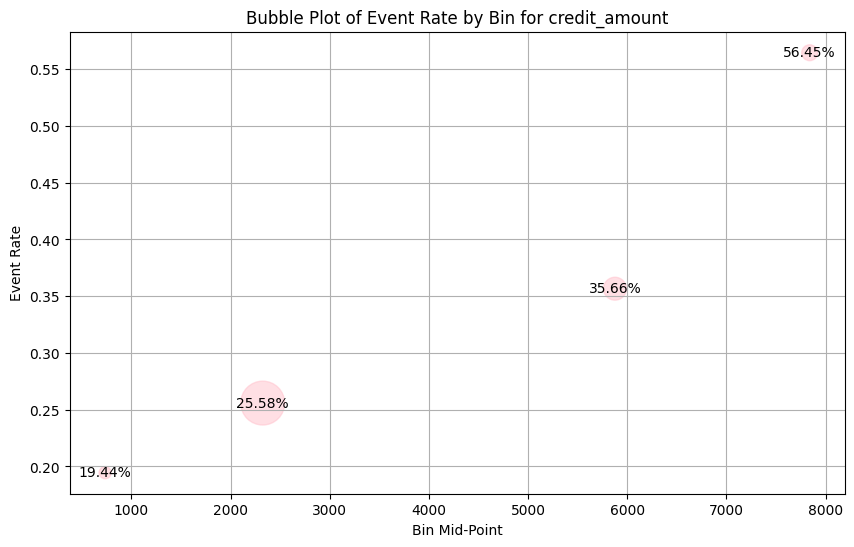

In [21]:
iv_transformer.plot_bubble_feature('credit_amount')